In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import joblib
import os
from pathlib import Path
import matplotlib.pyplot as plt # Make sure this is imported
import seaborn as sns # Make sure this is imported

# Add the parent directory to sys.path to import Config and FeatureExtractor
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(''), 'src')))
from config import Config
from ransomware_detector import FeatureExtractor

print("Libraries imported and Config/FeatureExtractor loaded.")

Libraries imported and Config/FeatureExtractor loaded.


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Ransomware Detection Model Evaluation

This notebook demonstrates the process of loading the generated training dataset, splitting it into training and testing sets, scaling features, training a Random Forest classifier, and evaluating its performance using various metrics such as accuracy, precision, recall, F1-score, and False Positive Rate. It also presents the classification report and confusion matrix.




In [2]:
# Load configuration
model_config = Config.get_model_config()['random_forest']
training_data_path = Config.TRAINING_DATASET_PATH

# Load dataset
print(f"Loading training data from: {training_data_path}")
try:
    df = pd.read_csv(training_data_path)
except FileNotFoundError:
    print(f" Error: Training data file not found at {training_data_path}")
    print("Please ensure `src/test_data/training_dataset.csv` exists, or run `python src/test_data_generator.py` to generate it.")
    raise

# Define features and labels
feature_extractor = FeatureExtractor()
X = df[feature_extractor.feature_names].values
y = df['label'].values

print(f"Dataset loaded with {len(X)} samples and {len(feature_extractor.feature_names)} features.")
print(f"Ransomware samples (label=1): {np.sum(y == 1)}")
print(f"Benign samples (label=0): {np.sum(y == 0)}")



Loading training data from: D:\ransomware-detection-system\src\test_data\training_dataset.csv
Dataset loaded with 100000 samples and 12 features.
Ransomware samples (label=1): 30728
Benign samples (label=0): 69272


## Data Preprocessing

Before training the model, the dataset is split into training and testing sets, and features are scaled to ensure optimal model performance.



In [3]:
# Split data into training and testing sets
print("Splitting data into training and testing sets (80/20 split)...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=model_config['random_state'], stratify=y)
print(f"Training set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")

# Scale features
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features scaled successfully.")



Splitting data into training and testing sets (80/20 split)...
Training set size: 80000 samples
Testing set size: 20000 samples
Scaling features...
Features scaled successfully.


## Model Training and Prediction

A Random Forest Classifier is initialized with parameters defined in `config.py` and then trained on the scaled training data. Predictions are then made on the test set.



In [4]:
# Initialize and train the Random Forest Classifier
print("Initializing and training Random Forest Classifier...")
model = RandomForestClassifier(
    n_estimators=model_config['n_estimators'],
    max_depth=model_config['max_depth'],
    min_samples_split=model_config['min_samples_split'],
    min_samples_leaf=model_config['min_samples_leaf'],
    random_state=model_config['random_state'],
    n_jobs=model_config['n_jobs']
)
model.fit(X_train_scaled, y_train)
print("✅ Model training completed.")

# Make predictions
print("Making predictions on the test set...")
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1] # Probability of ransomware
print("Predictions made successfully.")



Initializing and training Random Forest Classifier...
✅ Model training completed.
Making predictions on the test set...
Predictions made successfully.


## Model Evaluation

The trained model is evaluated using several key performance metrics, including Accuracy, Precision, Recall, F1-score, and False Positive Rate. A classification report and confusion matrix are also generated to provide a detailed understanding of the model's performance.



In [5]:
# Compute performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
false_positive_rate = fp / (fp + tn) if (fp + tn) != 0 else 0

# Display results
print("\n" + "=" * 50)
print("✨ Model Performance Metrics ✨")
print("=" * 50)

metrics_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'False Positive Rate'],
    'Value': [f'{accuracy:.4f}', f'{precision:.4f}', f'{recall:.4f}', f'{f1:.4f}', f'{false_positive_rate:.4f}']
})
print(metrics_table.to_string(index=False))

print("\n" + "=" * 50)
print("📊 Classification Report")
print("=" * 50)
print(classification_report(y_test, y_pred, target_names=['Benign', 'Ransomware']))

print("\n" + "=" * 50)
print("📉 Confusion Matrix")
print("=" * 50)
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual Benign', 'Actual Ransomware'], columns=['Predicted Benign', 'Predicted Ransomware'])
print(cm_df.to_string())
print(f"\nTrue Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")




✨ Model Performance Metrics ✨
             Metric  Value
           Accuracy 0.9807
          Precision 0.9806
             Recall 0.9559
           F1-score 0.9681
False Positive Rate 0.0084

📊 Classification Report
              precision    recall  f1-score   support

      Benign       0.98      0.99      0.99     13854
  Ransomware       0.98      0.96      0.97      6146

    accuracy                           0.98     20000
   macro avg       0.98      0.97      0.98     20000
weighted avg       0.98      0.98      0.98     20000


📉 Confusion Matrix
                   Predicted Benign  Predicted Ransomware
Actual Benign                 13738                   116
Actual Ransomware               271                  5875

True Negatives (TN): 13738
False Positives (FP): 116
False Negatives (FN): 271
True Positives (TP): 5875


## Saving the Trained Model and Scaler

The trained Random Forest model and the StandardScaler are saved to disk using `joblib` for future use by the ransomware detection system.



In [6]:
print("\n" + "=" * 50)
print("Saving trained model and scaler...")
Config.MODELS_DIR.mkdir(exist_ok=True)
joblib.dump(model, Config.DEFAULT_MODEL_PATH)
joblib.dump(scaler, Config.FEATURE_SCALER_PATH)
print(f"✅ Model saved to: {Config.DEFAULT_MODEL_PATH}")
print(f"✅ Scaler saved to: {Config.FEATURE_SCALER_PATH}")

print("\n✅ Model evaluation completed successfully.")




Saving trained model and scaler...
✅ Model saved to: D:\ransomware-detection-system\models\ransomware_model.joblib
✅ Scaler saved to: D:\ransomware-detection-system\models\feature_scaler.joblib

✅ Model evaluation completed successfully.


## Model Explainability with SHAP

SHAP (SHapley Additive exPlanations) is used to explain the output of the machine learning model. It connects optimal credit allocation with local explanations by using shapley values from game theory.


In [ ]:
# --- SHAP Explanations ---
print("\n" + "=" * 50)
print("🔬 Generating SHAP Explanations")
print("=" * 50)

# Load the trained model and scaler
loaded_model = joblib.load(Config.DEFAULT_MODEL_PATH)
loaded_scaler = joblib.load(Config.FEATURE_SCALER_PATH)

# Use a smaller subset of the test data for SHAP to speed up computation
X_test_sampled = X_test_scaled[np.random.choice(X_test_scaled.shape[0], 1000, replace=False)]

# Create a SHAP explainer
explainer = shap.TreeExplainer(loaded_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_sampled)

# Get feature names
feature_names = feature_extractor.feature_names

# Summary plot for overall feature importance
print("Generating SHAP summary plot...")
shap.summary_plot(shap_values[1], X_test_sampled, feature_names=feature_names, show=False)
plt.title('SHAP Summary Plot for Ransomware Detection (Class 1)')
plt.show()
print("✅ SHAP Summary Plot generated.")

# Dependence plots for top features (example for the top 2 features)
print("Generating SHAP dependence plots for top features...")

# Calculate mean absolute SHAP values to find top features
mean_abs_shap = np.abs(shap_values[1]).mean(0)
top_feature_indices = np.argsort(mean_abs_shap)[-2:] # Get indices of top 2 features

for i in top_feature_indices:
    shap.dependence_plot(i, shap_values[1], X_test_sampled, feature_names=feature_names, show=False)
    plt.title(f'SHAP Dependence Plot for {feature_names[i]}')
    plt.show()
print("✅ SHAP Dependence Plots generated.")

print("\n✅ SHAP explanation generation completed successfully.")



📊 Confusion Matrix Heatmap


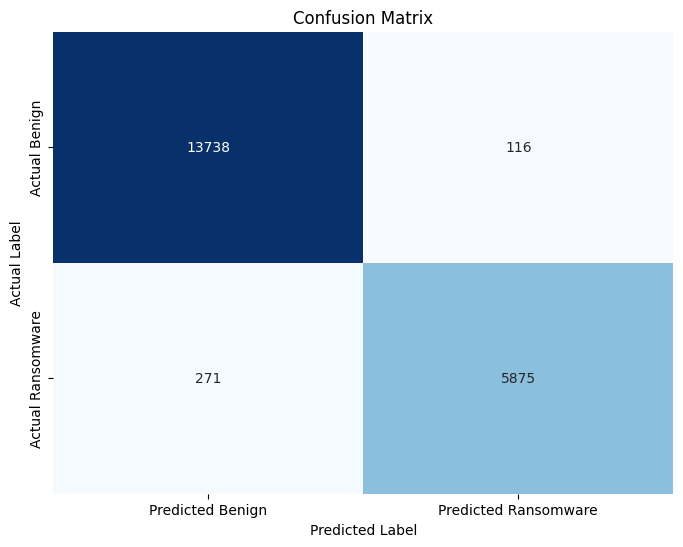

✅ Confusion Matrix Heatmap generated.


In [7]:
# --- Confusion Matrix Heatmap ---
print("\n" + "=" * 50)
print("📊 Confusion Matrix Heatmap")
print("=" * 50)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Benign', 'Predicted Ransomware'],
            yticklabels=['Actual Benign', 'Actual Ransomware'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

print("✅ Confusion Matrix Heatmap generated.")


📈 ROC Curve


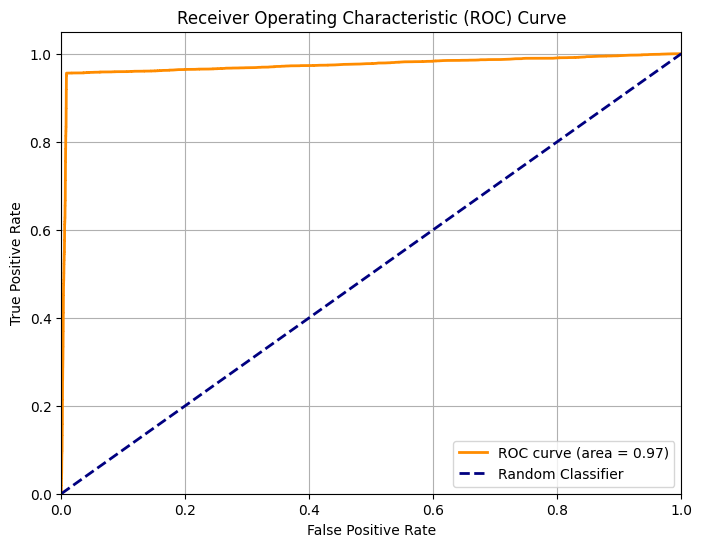

✅ ROC Curve generated.


In [8]:
# --- ROC Curve ---
print("\n" + "=" * 50)
print("📈 ROC Curve")
print("=" * 50)

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("✅ ROC Curve generated.")